In [121]:
import pandas as pd

dataFrame = pd.read_csv('dataset-gold-borobudur-prambanan-all.csv', nrows=1500 ,encoding='latin1')

data_text = dataFrame[['text', 'lokasi', 'daya_tarik', 'amenitas','aksesibilitas', 'citra', 'harga', 'sdm']]

data_text


,text,lokasi,daya_tarik,amenitas,aksesibilitas,citra,harga,sdm
0,"pengelolaanya sudah bagus, cuma akses keluar y...",Candi Borobudur,-,-,-1,-,-1,1
1,Bayar mahal2. Ada wc airnya gak ada. Sampel mu...,Candi Borobudur,-,-1,-,-,-1,-1
2,camdi borobudur yang terletak di kab. magelang...,Candi Borobudur,0,1,-,1,0,-
3,susana disana saya tidak pernah merasakan bosa...,Candi Borobudur,1,-,-,-,-,-
4,"Htm cukup mahal untuk ukuran candi,",Candi Borobudur,-,-,-,-,-1,-
...,...,...,...,...,...,...,...,...
1495,Great place to understand our country history,Candi Borobudur,1,-,-,-,-,-
1496,This is such a historic place. It would be goo...,Candi Borobudur,1,-,-,1,-,-
1497,Such an amazing place,Candi Borobudur,1,-,-,-,-,-
1498,This a culturally and historically significan...,Candi Borobudur,0,-,-,0,-,-


In [122]:
import numpy as np
import pandas as pd
import modSpellChecker as sc
from contractions import CONTRACTION_MAP
import re
import nltk
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import wordnet as wn
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [123]:

#  Data Preparation
data_text.shape

(1500, 8)

In [124]:

feature = data_text.iloc[:,0]

classification_mapping = {
    '-1': 'negative',
    '0': 'neutral',
    '1': 'positive',
    '-': 'none'
}

classification_columns = ['daya_tarik', 'amenitas','aksesibilitas', 'citra', 'harga', 'sdm']

for column in classification_columns:
    data_text.loc[:, column] = data_text[column].map(classification_mapping)

label1 = data_text['daya_tarik']
label2 = data_text['amenitas']
label3 = data_text['aksesibilitas']
label4 = data_text['citra']
label5 = data_text['harga']
label6 = data_text['sdm']


In [125]:
df = data_text['daya_tarik'].value_counts()

df

daya_tarik
positive    1097
none         233
neutral      152
negative      18
Name: count, dtype: int64

In [126]:
label1

0           none
1           none
2        neutral
3       positive
4           none
          ...   
1495    positive
1496    positive
1497    positive
1498     neutral
1499     neutral
Name: daya_tarik, Length: 1500, dtype: object

In [127]:
feature[0:10]

0    pengelolaanya sudah bagus, cuma akses keluar y...
1    Bayar mahal2. Ada wc airnya gak ada. Sampel mu...
2    camdi borobudur yang terletak di kab. magelang...
3    susana disana saya tidak pernah merasakan bosa...
4                  Htm cukup mahal untuk ukuran candi,
5    Sebagai salah satu warisan dunia, borobudur me...
6    Candinya yang penuh akan histori, tapi lebih b...
7    Di foto keren nyata nya lbh keren , emg luar b...
8    Bagus kamarnya Luas.\nBersih serta strategis k...
9    Tempat enak nyaman bersih bagus buat liburan, ...
Name: text, dtype: object

In [128]:
# Normalisasi Data
character =['z','y','x','w','v','u','t','s','r','q','p','o','n','m','l','k','j','i','h','g','f',
            'e','d',',','.',';',':','-','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@']
def repeatcharNormalize(text):
    for i in range(len(character)):
        charac_long = 5
        while charac_long>=2:
            char=character[i]*charac_long
            text=text.replace(char,character[i])
            charac_long-=1
        return text
def spellNormalize(text):
    spellCheck = []
    for i in text:
        if i not in character:
            j=sc.correction(i)
            spellCheck.append(j)
        else:
            spellCheck.append(i)
        return spellCheck
def tokenize_text(text):
    tokens=nltk.word_tokenize(text)
    tokens=[token.strip() for token in tokens]
    return tokens
def expand_contractions(text, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                        flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                               if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'","", expanded_text)
    return expanded_text
def stemmer_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)
    return text



In [129]:
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('',token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

factory = StopWordRemoverFactory()
stopword_list = factory.get_stop_words()

def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def normalize_corpus(corpus, tokenize=False):
    normalized_corpus = []
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
        text = stemmer_text(text)
        text = remove_special_characters(text)
        text = repeatcharNormalize(text)
        text = remove_stopwords(text)
        normalized_corpus.append(text)
        if tokenize:
            text = tokenize_text(text)
            text = spellNormalize(text)
            normalized_corpus.append(text)
    # print(normalized_corpus)
    return normalized_corpus


In [130]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=0.33,
                                                        random_state=42)
    return train_X, test_X, train_Y, test_Y

train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(feature,label1,test_data_proportion=0.3)



In [131]:
# Normalize Data
norm_train_corpus = normalize_corpus(train_corpus)

In [132]:
norm_train_corpus[0:10]

['panas bgtttt biasa aja mehong bgttt 50 rb masuk dgn jalan yg jauh kurang fasilitas utk kendara cuman beberapa banding sm wisatawan yg masuk semua pakai uang padahal candi byk yg rusak truz pas mau pulang udh cape bawa puterin keliling toko2',
 'sangat senang lestari budidaya indonesia',
 'sangat bagus indah cuman betul krmarin pas kesana cuaca dukung hujan nya sangat deras anginny kencang sekli jdi ggl g naik atas',
 'the biggest buddhist temple in the world always fascinating',
 'world heritage',
 'tempat wisata sejarah yg jadi waris budaya dunia sangat manfaat sekali utama ajar wisata borobudur kenal salah satu tinggal sejarah indonesia yg jadi waris budaya dunia',
 'one of seven wonder beautiful place not the management i give 3 stars for make us walking through all the souvenirs maze that never ends with my kids complaining want to go back to the car asap at least they have to provide the option to go back to the car with direct route we paid for the temple not to see the souveni

In [133]:
norm_test_corpus = normalize_corpus(test_corpus)


In [134]:
norm_test_corpus[0:10]


['you might need the experience to visit the worlds largest buddhist temple',
 'awesome',
 'salah satu tempat sangat indah indonesia',
 'wisata murah riah buat keluarga tiket rp 50 000 dewasa rp 25 000 anak2 berangkat pagi siang unjung makin membludak',
 'cukup komersial kunjung harga tiket 50 ribu yg turut cukup mahal kunjung lihat candi',
 'sungguh pandang sangat kagum pandang buat takjub jadi bayang bagaimana proses bangun jaman kala sungguh sangat luar biasa karya seni tingkat tinggi dasar kultural religi',
 'amazing structure zabur duplicate',
 'candi borobudur ajaib dunia yg tdk dipungkiri',
 'you can come here by taking a bus from jombor bus station in yogyakarta for 30k and if you want to go back to yogya at 67 pm you can just take a bus back for the same price from the bus station where you arrived alot cheaper that the tours',
 'the largest buddhist temple in the world inti keren banget candi pas weekend selalu rame sama anak sekolah orang libur maupun turis hari mutermuter c

In [135]:
# Ekstraksi Fitur

In [136]:
#Fungsi untuk mengekstraksi feature menggunakan TF-IDF Model
def tfidf_transformer(bow_matrix):
    transformer = TfidfTransformer(norm='l2',
                                   smooth_idf=True,
                                   use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix


def tfidf_extractor(corpus, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(min_df=1,
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [137]:
#mengunakan model TF-IDF untuk mengekstraksi feature
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(norm_train_corpus)
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)


In [138]:
from sklearn.linear_model import SGDClassifier

train_features=tfidf_train_features
train_labels=train_labels

test_features=tfidf_test_features
test_labels=test_labels

In [139]:
df_train = pd.DataFrame()
df_train['norm_train'] = norm_train_corpus
df_train['train_labels'] = train_labels
df_test = pd.DataFrame()
df_test['norm_test'] = norm_test_corpus
df_test['test_labels'] = test_labels


In [140]:
df_train.head()

,norm_train,train_labels
0,panas bgtttt biasa aja mehong bgttt 50 rb masu...,none
1,sangat senang lestari budidaya indonesia,none
2,sangat bagus indah cuman betul krmarin pas kes...,neutral
3,the biggest buddhist temple in the world alway...,positive
4,world heritage,none


In [141]:
df_test.head()

,norm_test,test_labels
0,you might need the experience to visit the wor...,NaN
1,awesome,NaN
2,salah satu tempat sangat indah indonesia,NaN
3,wisata murah riah buat keluarga tiket rp 50 00...,NaN
4,cukup komersial kunjung harga tiket 50 ribu yg...,NaN


In [142]:
train_features[0:1]

<1x3640 sparse matrix of type '<class 'numpy.float64'>'
	with 39 stored elements in Compressed Sparse Row format>

In [143]:
train_labels[0:1]

591    negative
Name: daya_tarik, dtype: object

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
}

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(train_features, train_labels)

best_clf = grid_search.best_estimator_
best_predictions = best_clf.predict(test_features)

print("Label test: \n" + format(test_labels[:10]))
# print("Prediction test: \n"+ format(predictions[:10]))

print("Prediction test: \n"+ format(best_predictions[:10]))


Label test: 
1116    positive
1368    positive
422     positive
413         none
451     negative
861     positive
1063    positive
741     positive
1272        none
259     positive
Name: daya_tarik, dtype: object
Prediction test: 
['positive' 'positive' 'positive' 'positive' 'none' 'positive' 'positive'
 'neutral' 'positive' 'positive']


In [145]:
print("Accuration: "+format(best_clf.score(test_features,test_labels)))

Accuration: 0.7313131313131314


In [146]:
def get_metrics(true_labels, predicted_labels):
    print('Accuracy: ', np.round(metrics.accuracy_score(true_labels, predicted_labels),2))
    print('Precision: ', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted',zero_division=1),2))
    print('Recall: ', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'),2))
    print('F1 Score: ', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'),2))

    
# mengevaluasi performa prediksi menggunakan model
get_metrics(true_labels=test_labels,predicted_labels=best_predictions)

Accuracy:  0.73
Precision:  0.69
Recall:  0.73
F1 Score:  0.68


In [147]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([('vect', tfidf_vectorizer),
                        ('chi',  SelectKBest(chi2, k=1200)),
                        ('clf', LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False))])

model = pipeline.fit(train_corpus, train_labels)
predictions = model.predict(test_corpus)
print("Label test: \n" + format(test_labels[:10]))
print("Prediction test: \n"+ format(predictions[:10]))
print("Accuration: "+format(model.score(test_corpus,test_labels)))

Label test: 
1116    positive
1368    positive
422     positive
413         none
451     negative
861     positive
1063    positive
741     positive
1272        none
259     positive
Name: daya_tarik, dtype: object
Prediction test: 
['positive' 'positive' 'positive' 'positive' 'none' 'positive' 'positive'
 'positive' 'positive' 'positive']
Accuration: 0.7515151515151515


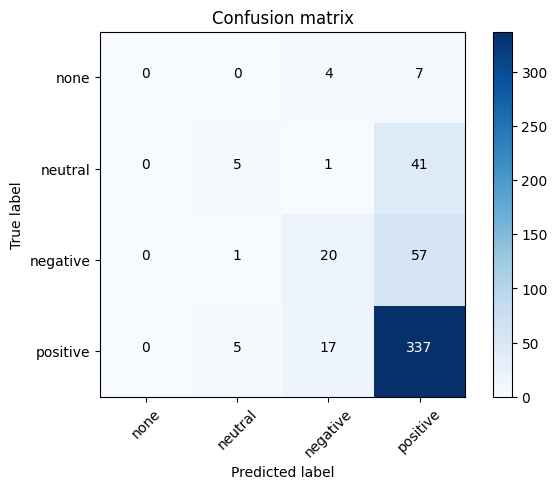

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else str(cm[i, j]), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# define cnf_matrix here
cnf_matrix = confusion_matrix(test_labels, best_predictions)

plot_confusion_matrix(cnf_matrix, classes=['none', 'neutral', 'negative', 'positive'], title='Confusion matrix')
